# Integer Scheduling Problem

In the [previous problem](02_Linear_Scheduling.ipynb), we solved the scheduling problem using **continuous linear decision variables**.

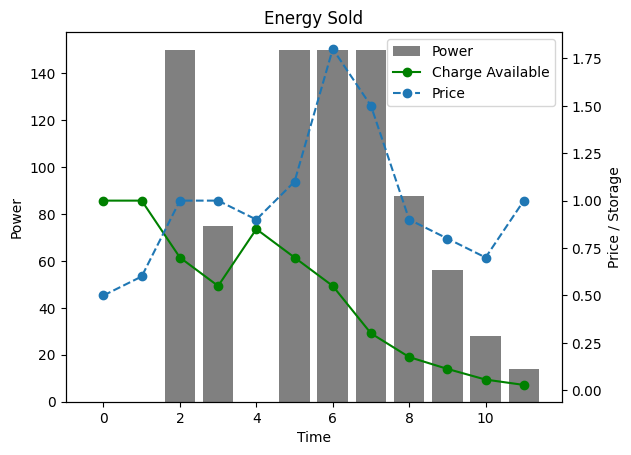

From the results, we observe that power is produced during **9 time periods**, during which the battery is fully utilized.

We now introduce a **new integer (binary) decision variable**.  
The goal is to impose an operational constraint such that the battery must deliver power at at least 50% of $ W^{max}  $ for **a minimum of 8 time periods**.

This transforms the model from a linear program (LP) into a mixed-integer linear program (MILP).



## Introduction to MILP

### What is MILP

**Mixed-Integer Linear Programming (MILP)** extends Linear Programming (LP) by allowing **binary or integer decision variables** in addition to continuous ones.

* LP → continuous variables only
* MILP → continuous variables **+** integer / binary logic

To connect **logic decisions (yes/no, on/off)** with **linear equations**, we often use **Big-M constraints**.

---

### What are Big-M Constraints

A **Big-M constraint** is a modeling technique that allows a constraint to be:

* **enforced** when a binary variable is ON (1)
* **relaxed** when the binary variable is OFF (0)

In simple terms:

> **Big-M constraints are how we connect logic with math.**

---

### Simple Intuitive Example (Coffee ☕)

Let’s say:

* I normally can write **at most 20 lines of code**
* **If I drink coffee**, I can write **at most 10 extra lines**
* Drinking coffee is a **yes/no decision**

---

#### Decision Variables

**Binary variable (logic):**
$ c \in \{0,1\} $

* $c = 1$ → I drink coffee
* $c = 0$ → I do not drink coffee

**Continuous variable (output):**
$ n = \text{total lines of code written} $

---

### Desired Logic (in words)

* If I **don’t drink coffee**, then
  $ n \leq 20 $
* If I **drink coffee**, then
  $ n \leq 30 $

### Other Constraints
* Non-Negativity
  $ n \geq 0 $

---

### Mathematical Formulation (Big-M Constraint)

We use a **large constant (M)** (called *Big-M*):  
Big-M is not always a huge number.
> Big-M = the largest value needed to fully relax a constraint (i.e. turn off the constraint)

So:
in this example → M = 10

$ n \leq 20 + 10c $

Why this works:

| Coffee (c) | Constraint becomes | Result           |
| ---------- | ------------------ | ---------------- |
| 0          | $n \leq 20$         | no extra lines   |
| 1          | $n \leq 30$         | bonus unlocked ☕ |

The binary variable **turns on/off** the extra capacity.

**What does it mean to "relax the constraint":**
> A constraint is fully relaxed when it is guaranteed not to restrict the variable anymore.

#### General Rule in Choosing the M
If $ M $ is:
* Too small -> constraint still restricts (wrong logic)
* Too large -> solver becomes slow/unstable
* Just right -> clean logic + fast solver

---

### Objective Function (optional)

If we want to **maximize productivity**:

$ \max n$

The solver will choose:

* $c = 1$ (drink coffee)
* $n \leq 30$

**Note:**
> Notice how the objective **does not** reference the binary variable directly;  
> instead, the binary variable affects the feasible region through constraints
---

### Why This is Called “Big-M”

* $M$ is a **large value** needed to fully relax a constraint
* When the binary is OFF → constraint is relaxed/off
* When the binary is ON → constraint is enforced/on (may become binding)

---

TLDR

> Big-M constraints allow binary variables to activate or deactivate linear constraints, enabling logical decisions inside MILP models.


## Code

### Import Libraries

In [1]:
import pyomo.environ as pyomo
import matplotlib.pyplot as plt

### The data

In [2]:
# P_t: Electricity price at each time step
P_t = {
    0 : 0.5,
    1 : 0.6,
    2 : 1.0,
    3 : 1.0,
    4 : 0.9,
    5 : 1.1,
    6 : 1.8,
    7 : 1.5,
    8 : 0.9,
    9 : 0.8,
    10 : 0.7,
    11 : 1.0
}

# Q_t: Energy inflow (charging) at each time step
Q_t = {
    0 : 0.,
    1 : 0.,
    2 : 0.,
    3 : 0.,
    4 : 0.3,
    5 : 0.15,
    6 : 0.15,
    7 : 0.05,
    8 : 0.05,
    9 : 0.05,
    10 : 0.,
    11 : 0.
}


NOTE:  
`P_t` and `Q_t` are dictionaries that map each time step (0 to 11) to a value.

`P_t[t]` gives the electricity price at time `t`.

`Q_t[t]` gives the energy coming into the storage at time `t`.

Pyomo uses these dictionaries to iterate over the time steps when defining constraints and the objective function.

The format ensures Pyomo can automatically link each variable and constraint to the correct time step.

#### Visualization of the Price and Energy Input

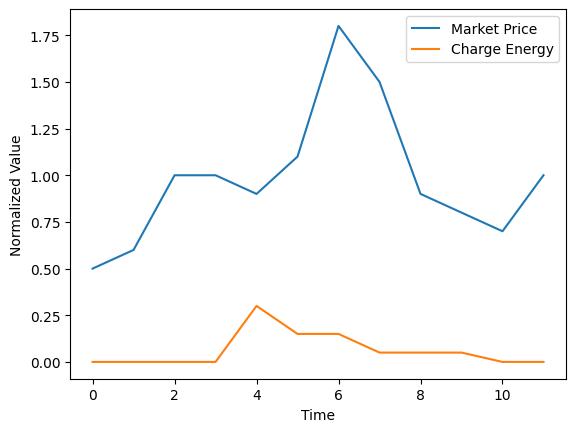

In [3]:
plt.plot(range(12), [P_t[i] for i in range(12)], label="Market Price")
plt.plot(range(12), [Q_t[i] for i in range(12)], label="Charge Energy")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

### Initialize Pyomo Model

In [4]:
model = pyomo.ConcreteModel()

### Creating Variables

In [5]:
# Initialize a set of time steps
model.T = pyomo.Set(initialize=P_t.keys())

# Sales price at each time step
model.price = pyomo.Param(model.T, initialize=P_t)
# this means the values in model.price will correspond to the keys from P_t dictionary where model.T would act as the indexer to retrieve the values

# Energy inflow (charging) at each time step
model.charge = pyomo.Param(model.T, initialize=Q_t)
# this means the values in model.charge will correspond to the keys from Q_t dictionary

# Initial/Maximum charge capacity
model.S0 = pyomo.Param(initialize=500.)

# Maximum instanteous power
model.wmax = pyomo.Param(initialize=150.)

"""Decision Variables"""
# Power Output at t
model.w = pyomo.Var(model.T, domain=pyomo.NonNegativeReals)
# This time we pass model.T (the set) as one of the argumets so that pyomo can assign how much power output at eeach timestamp t

# Energy Stored at t
model.s = pyomo.Var(model.T, domain=pyomo.NonNegativeReals)
# This time we pass model.T (the set) as one of the argumets so that pyomo can assign how much energy would be stored at eeach timestamp t

# Operational State (1 if on, 0 otherwise)
model.y = pyomo.Var(model.T, domain=pyomo.Binary)


### Objective Function

In [6]:
# this time we would pass a function as the objective
def obj_func(model): # in Pyomo, the model is always passed in
    # sum of all the revenue at t
    return sum([model.w[t] * model.price[t] for t in model.T])

model.objective = pyomo.Objective(rule = obj_func, 
                                  sense = pyomo.maximize
                                  )

### Constraints

In [7]:
# we will make functions for each constraints due to the constraints is time based (more complicated lol)

# The maximum battery/storage capacity (where previously we assume the maximum battery/storage capacity is the initial capacity)
def constr_battery_capacity(model, t): # we have two arguments. the model and the timestep since we assume pyomo would return the time step too
    return model.s[t] <= model.S0

model.constr_battery_capacity = pyomo.Constraint(model.T, # The model is passed so that pyomo can iterate over the timestep and evaluate
                                                 rule = constr_battery_capacity)

# Power Output Constraint (limited by wmax and of the power is on)
def constr_power(model, t):
    return model.w[t] <= model.wmax * model.y[t]

model.constr_power = pyomo.Constraint(model.T,
                                      rule = constr_power)

# energy balance on battery based on power consumed
def constr_battery_balance(model, t):
    if t == model.T.first():
        # initial storage at step 0
        return model.s[t] == model.S0 - model.w[t] + model.charge[t]*model.S0
    else:
        return model.s[t] == model.s[t-1] - model.w[t] + model.charge[t]*model.S0

model.constr_battery_balance = pyomo.Constraint(model.T,
                                               rule = constr_battery_balance)

# Another power output constraint where we cant sell more than we have
def constr_energy_available(model, t):
    return model.w[t] <= model.s[t]

model.constr_energy_available = pyomo.Constraint(model.T,
                                                 rule = constr_energy_available
                                                 )

"""New constraints"""
# Minimum amount of times the power needs to be on
def constr_min_runtime(model):
    return sum(model.y[t] for t in model.T) >= 8

model.constr_min_runtime = pyomo.Constraint(rule = constr_min_runtime) # the model isnt passed because we are referencing a global variable in the model

# Set the minimum power produced when the battery is on
def constr_min_produce(model, t):
    return model.w[t] >= 0.5 * model.wmax * model.y[t]

model.constr_min_produce = pyomo.Constraint(model.T,
                                        rule = constr_min_produce)

### Objective Function

In [8]:
# this time we would pass a function as the objective
def obj_func(model): # in Pyomo, the model is always passed in
    # sum of all the revenue at t
    return sum([model.w[t] * model.price[t] for t in model.T])

model.objective = pyomo.Objective(rule = obj_func, 
                                  sense = pyomo.maximize
                                  )

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.AbstractScalarObjective'>).
This is usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


### Creating Solver

In [9]:
solver = pyomo.SolverFactory("glpk")
result = solver.solve(model)

#### Results

In [10]:
print(result)


Problem: 
- Name: unknown
  Lower bound: 992.5
  Upper bound: 992.5
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 36
  Number of nonzeros: 131
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 9
      Number of created subproblems: 9
  Error rc: 0
  Time: 0.002986431121826172
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



##### Display Model
this includes constraints and variables

In [11]:
print(model.display())

Model unknown

  Variables:
    w : Size=12, Index=T
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          0 :     0 :                0.0 :  None : False : False : NonNegativeReals
          1 :     0 :                0.0 :  None : False : False : NonNegativeReals
          2 :     0 :               75.0 :  None : False : False : NonNegativeReals
          3 :     0 :               75.0 :  None : False : False : NonNegativeReals
          4 :     0 :               75.0 :  None : False : False : NonNegativeReals
          5 :     0 :              125.0 :  None : False : False : NonNegativeReals
          6 :     0 :              150.0 :  None : False : False : NonNegativeReals
          7 :     0 :              150.0 :  None : False : False : NonNegativeReals
          8 :     0 :               75.0 :  None : False : False : NonNegativeReals
          9 :     0 : 7.105427357601e-15 :  None : False : False : NonNegativeReals
         10 :     0 :            

##### Optimization Results

General Rule in Extracting the Values of the Optimization
| Component     | How to access value   |
| ------------- | --------------------- |
| `pyomo.Var`   | `model.x[t]()`      |
| `pyomo.Param` | `model.p[t]`        |
| `pyomo.Param` | `value(model.p[t])` |

In [12]:
print(f"time \t price \t power \t charge_available")
for t in model.T:
    print(f"{t} \t {model.price[t]:.2f} \t {model.w[t]():>5.1f} \t {model.s[t]():5.1f}")

time 	 price 	 power 	 charge_available
0 	 0.50 	   0.0 	 500.0
1 	 0.60 	   0.0 	 500.0
2 	 1.00 	  75.0 	 425.0
3 	 1.00 	  75.0 	 350.0
4 	 0.90 	  75.0 	 425.0
5 	 1.10 	 125.0 	 375.0
6 	 1.80 	 150.0 	 300.0
7 	 1.50 	 150.0 	 175.0
8 	 0.90 	  75.0 	 125.0
9 	 0.80 	   0.0 	 150.0
10 	 0.70 	   0.0 	 150.0
11 	 1.00 	  75.0 	  75.0


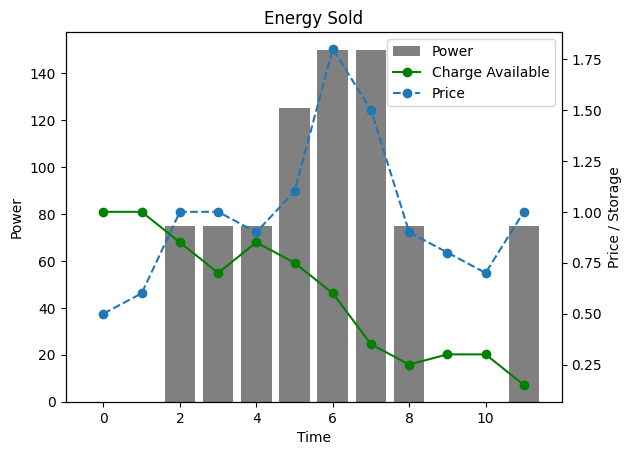

In [13]:
fig, ax1 = plt.subplots()

# Power (left axis)
ax1.bar(range(len(P_t)), [model.w[t]() for t in model.T], color="gray", label="Power")
ax1.set_ylabel("Power")
ax1.set_xlabel("Time")

# Second axis
ax2 = ax1.twinx()
ax2.plot(
    range(len(P_t)),
    [model.s[t]() / model.S0 for t in model.T],
    color="green",
    label="Charge Available",
    marker="o"
)
ax2.plot(
    range(len(P_t)),
    [model.price[t] for t in model.T],
    label="Price",
    linestyle="--",
    marker="o"
)
ax2.set_ylabel("Price / Storage")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

plt.title("Energy Sold")
plt.show()
